<a href="https://colab.research.google.com/github/mohamed-habib-jaberi/Deep-Learning/blob/main/Transfer_Learning_with_TensorFlow_Part_3__Scaling_up_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up

In [75]:
# Check to see if we're using a GPU
!nvidia-smi

Wed Oct 22 22:49:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |    2164MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Creating helper functions**

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [76]:
!wget https://raw.githubusercontent.com/mohamed-habib-jaberi/Deep-Learning/refs/heads/main/Computer%20Vision%20and%20CNN%20in%20TensorFlow/helper_functions.py

--2025-10-22 22:49:40--  https://raw.githubusercontent.com/mohamed-habib-jaberi/Deep-Learning/refs/heads/main/Computer%20Vision%20and%20CNN%20in%20TensorFlow/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10245 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    in 0s      

2025-10-22 22:49:41 (108 MB/s) - ‘helper_functions.py.2’ saved [10245/10245]



In [77]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir



**101 Food Classes: working with less data**

In [78]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-10-22 22:49:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 74.125.24.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G  23.2MB/s    in 70s     

2025-10-22 22:50:50 (22.3 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In [79]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/guacamole'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/red_velvet_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/edamame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '101_foo

In [80]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


**Train a our model with transfer learning on 10% of 101 food classes**


Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [81]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [82]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [83]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [84]:
# Get a summary of model we've created
model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [85]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.1574 - loss: 3.9844 - val_accuracy: 0.4301 - val_loss: 2.5688
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.4813 - loss: 2.3414 - val_accuracy: 0.5037 - val_loss: 2.0638
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.5459 - loss: 1.9210 - val_accuracy: 0.5323 - val_loss: 1.8615
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.5881 - loss: 1.6955 - val_accuracy: 0.5453 - val_loss: 1.7887
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.6214 - loss: 1.5534 - val_accuracy: 0.5358 - val_loss: 1.7710


In [86]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.5633 - loss: 1.6693


[1.5955992937088013, 0.5819405913352966]

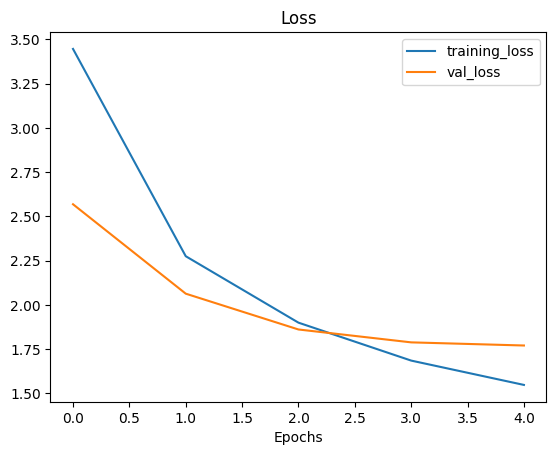

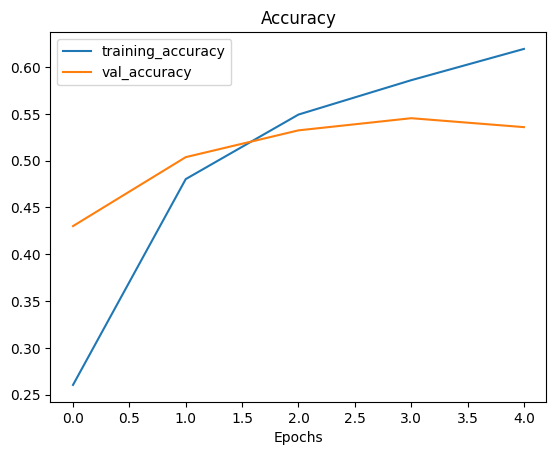

In [87]:
plot_loss_curves(history_all_classes_10_percent)

**Fine-tuning**

In [88]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [89]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [90]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [91]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_4 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [92]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 48s 153ms/step - accuracy: 0.6212 - loss: 1.5279 - val_accuracy: 0.5609 - val_loss: 1.6839
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - accuracy: 0.6782 - loss: 1.3321 - val_accuracy: 0.5715 - val_loss: 1.6409
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - accuracy: 0.6872 - loss: 1.2380 - val_accuracy: 0.5681 - val_loss: 1.6258
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - accuracy: 0.7044 - loss: 1.1692 - val_accuracy: 0.5802 - val_loss: 1.5851
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - accuracy: 0.7260 - loss: 1.1055 - val_accuracy: 0.5826 - val_loss: 1.5625
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - accuracy: 0.7415 - loss: 1.0489 - val_accuracy: 0.5916 - val_loss: 1.5270


In [93]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 78ms/step - accuracy: 0.6012 - loss: 1.4906


[1.418157935142517, 0.6186534762382507]

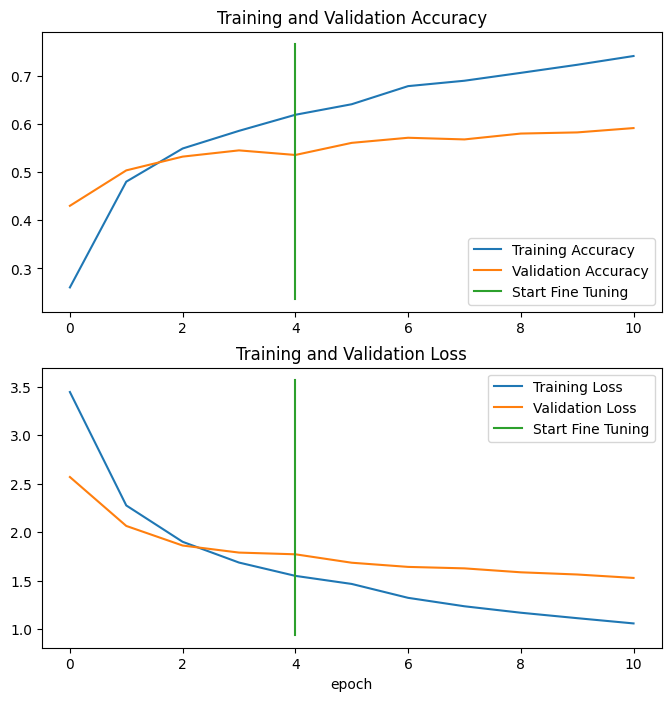

In [94]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

**Saving and loading our model**

To use our model in an external application, we'll need to save it and export it somewhere.

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
# Save (new format)
model.save("/content/drive/MyDrive/models/my_model.keras")

In [97]:
# Load
from tensorflow import keras
loaded_model = keras.models.load_model(
    "/content/drive/MyDrive/models/my_model.keras",
    custom_objects={"RandomHeight": keras.layers.RandomHeight}
)

In [98]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 77ms/step - accuracy: 0.6012 - loss: 1.4906


[1.418157935142517, 0.6186534762382507]

In [99]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.418157935142517, 0.6186534762382507]

**Evaluating the performance of the big dog model across all different classes**

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [100]:
# Download pretrained model (one that was prepared earlier, so all predictions are similar)

!wget https://github.com/mohamed-habib-jaberi/Deep-Learning/raw/main/my_model.zip

--2025-10-22 23:01:49--  https://github.com/mohamed-habib-jaberi/Deep-Learning/raw/main/my_model.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mohamed-habib-jaberi/Deep-Learning/main/my_model.zip [following]
--2025-10-22 23:01:49--  https://raw.githubusercontent.com/mohamed-habib-jaberi/Deep-Learning/main/my_model.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22167828 (21M) [application/zip]
Saving to: ‘my_model.zip.1’

my_model.zip.1      100%[===================>]  21.14M  --.-KB/s    in 0.04s   

2025-10-22 23:01:50 (486 MB/s) - ‘my_model.zip.1’ saved [22167828/22167828]



In [101]:
unzip_data("/content/my_model.zip")

In [102]:
# Load in saved model
model = tf.keras.models.load_model("/content/my_model.keras")


In [103]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 68s 79ms/step - accuracy: 0.5937 - loss: 1.5210


[1.423581838607788, 0.6148514747619629]

**Making predictions with our trained model**

In [104]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left



790/790 ━━━━━━━━━━━━━━━━━━━━ 64s 78ms/step


In [105]:
len(test_data)

790

In [106]:
# How many predictions are there?
len(preds_probs)

25250

In [107]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [108]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[3.3125988e-01, 2.7477011e-04, 2.3423572e-01, ..., 2.7464133e-05,
        4.5708367e-03, 5.1361313e-03],
       [8.5744506e-01, 3.5241305e-06, 3.9286301e-03, ..., 2.8570041e-03,
        4.1785038e-06, 4.1823696e-05],
       [2.6479909e-01, 8.4453980e-03, 3.2256991e-02, ..., 1.7954697e-03,
        1.1914475e-03, 3.9989878e-03],
       ...,
       [2.1693510e-01, 3.6563779e-05, 2.6090713e-03, ..., 4.3609343e-02,
        6.1641447e-04, 2.6392814e-04],
       [1.2917376e-01, 3.9837745e-04, 3.1177565e-01, ..., 1.5723810e-03,
        2.6560487e-04, 5.5341079e-04],
       [7.8090924e-01, 3.3198621e-06, 3.2799540e-03, ..., 2.6943446e-03,
        1.3939670e-05, 1.0044639e-03]], dtype=float32)

In [109]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.31259876e-01, 2.74770107e-04, 2.34235719e-01, 1.17081493e-06,
        5.85138696e-05, 1.34714155e-05, 4.18388459e-04, 3.16777478e-05,
        1.44734103e-02, 1.90265811e-04, 5.82287203e-06, 1.22587780e-05,
        1.87336386e-03, 2.14140391e-06, 5.39985904e-03, 1.67411414e-03,
        1.45845625e-04, 2.12298241e-03, 1.24485139e-02, 3.34511606e-05,
        2.91203451e-03, 1.13326896e-04, 9.52748174e-04, 2.32975988e-04,
        5.59849024e-04, 2.51452858e-03, 1.67048816e-03, 1.98688620e-04,
        5.03135435e-02, 1.42686989e-03, 7.20992557e-06, 1.09088002e-03,
        6.72440918e-04, 1.67304552e-05, 3.54329846e-03, 6.72307215e-05,
        4.16946335e-04, 1.81935774e-03, 6.03973120e-02, 2.90314871e-04,
        9.32799769e-04, 5.31201856e-03, 1.10232714e-03, 2.62098583e-05,
        1.81251628e-04, 5.55465194e-05, 2.66090385e-03, 1.16487376e-04,
        1.69448849e-05, 2.06251405e-02, 2.38905952e-04, 1.52417095e-04,
        8.47076550e-02, 1.56975333e-02, 2.03410877e-04, 1.284694

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [110]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")



Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [3.31259876e-01 2.74770107e-04 2.34235719e-01 1.17081493e-06
 5.85138696e-05 1.34714155e-05 4.18388459e-04 3.16777478e-05
 1.44734103e-02 1.90265811e-04 5.82287203e-06 1.22587780e-05
 1.87336386e-03 2.14140391e-06 5.39985904e-03 1.67411414e-03
 1.45845625e-04 2.12298241e-03 1.24485139e-02 3.34511606e-05
 2.91203451e-03 1.13326896e-04 9.52748174e-04 2.32975988e-04
 5.59849024e-04 2.51452858e-03 1.67048816e-03 1.98688620e-04
 5.03135435e-02 1.42686989e-03 7.20992557e-06 1.09088002e-03
 6.72440918e-04 1.67304552e-05 3.54329846e-03 6.72307215e-05
 4.16946335e-04 1.81935774e-03 6.03973120e-02 2.90314871e-04
 9.32799769e-04 5.31201856e-03 1.10232714e-03 2.62098583e-05
 1.81251628e-04 5.55465194e-05 2.66090385e-03 1.16487376e-04
 1.69448849e-05 2.06251405e-02 2.38905952e-04 1.52417095e-04
 8.47076550e-02 1.56975333e-02 2.03410877e-04 1.28469467e-02
 1.26701314e-02 1.75866869e-03 3.09059513e-

In [111]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29, 46,  2,  0])

In [112]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [113]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [114]:
# How many y_labels are there?
len(y_labels)

25250

In [117]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [116]:
len(test_data)

790

# Evaluating our model's predictions

One way to check that our model's predictions array (pred_classes) is in the same order as our test labels array (y_labels) is to find the accuracy score.

In [115]:
results_downloaded_model

[1.423581838607788, 0.6148514747619629]

In [118]:

# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6148514851485148

In [119]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

np.True_

**Let's get visual: making a confusion matrix**

In [120]:
from helper_functions import make_confusion_matrix

In [121]:

# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [122]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [123]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

**Let's keep the evaluation train going, time for a classification report**

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification_report, let's try it out.

In [124]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.35      0.19      0.24       250
           1       0.53      0.74      0.62       250
           2       0.59      0.67      0.62       250
           3       0.85      0.53      0.65       250
           4       0.54      0.48      0.51       250
           5       0.46      0.44      0.45       250
           6       0.79      0.78      0.78       250
           7       0.87      0.75      0.81       250
           8       0.22      0.66      0.32       250
           9       0.41      0.67      0.51       250
          10       0.55      0.42      0.47       250
          11       0.71      0.67      0.69       250
          12       0.77      0.60      0.68       250
          13       0.60      0.51      0.55       250
          14       0.53      0.64      0.58       250
          15       0.42      0.40      0.41       250
          16       0.67      0.54      0.60       250
          17       0.45    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [125]:

# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.34558823529411764,
  'recall': 0.188,
  'f1-score': 0.24352331606217617,
  'support': 250.0},
 '1': {'precision': 0.5302593659942363,
  'recall': 0.736,
  'f1-score': 0.6164154103852596,
  'support': 250.0},
 '2': {'precision': 0.5859649122807018,
  'recall': 0.668,
  'f1-score': 0.6242990654205608,
  'support': 250.0},
 '3': {'precision': 0.8516129032258064,
  'recall': 0.528,
  'f1-score': 0.6518518518518519,
  'support': 250.0},
 '4': {'precision': 0.5426008968609866,
  'recall': 0.484,
  'f1-score': 0.5116279069767442,
  'support': 250.0},
 '5': {'precision': 0.45867768595041325,
  'recall': 0.444,
  'f1-score': 0.45121951219512196,
  'support': 250.0},
 '6': {'precision': 0.7894736842105263,
  'recall': 0.78,
  'f1-score': 0.7847082494969819,
  'support': 250.0},
 '7': {'precision': 0.8744186046511628,
  'recall': 0.752,
  'f1-score': 0.8086021505376344,
  'support': 250.0},
 '8': {'precision': 0.21502590673575128,
  'recall': 0.664,
  'f1-score': 0.324853228

In [126]:
class_names[98]

'tiramisu'

In [127]:
classification_report_dict["99"]["f1-score"]

0.3866943866943867

In [128]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24352331606217617,
 'baby_back_ribs': 0.6164154103852596,
 'baklava': 0.6242990654205608,
 'beef_carpaccio': 0.6518518518518519,
 'beef_tartare': 0.5116279069767442,
 'beet_salad': 0.45121951219512196,
 'beignets': 0.7847082494969819,
 'bibimbap': 0.8086021505376344,
 'bread_pudding': 0.324853228962818,
 'breakfast_burrito': 0.5106382978723404,
 'bruschetta': 0.47380410022779046,
 'caesar_salad': 0.688659793814433,
 'cannoli': 0.6756756756756757,
 'caprese_salad': 0.5529157667386609,
 'carrot_cake': 0.5822784810126582,
 'ceviche': 0.406570841889117,
 'cheese_plate': 0.5955555555555555,
 'cheesecake': 0.430062630480167,
 'chicken_curry': 0.5009633911368016,
 'chicken_quesadilla': 0.6652631578947369,
 'chicken_wings': 0.7234848484848485,
 'chocolate_cake': 0.5665236051502146,
 'chocolate_mousse': 0.3629191321499014,
 'churros': 0.7535641547861507,
 'clam_chowder': 0.7366336633663366,
 'club_sandwich': 0.7040358744394619,
 'crab_cakes': 0.416,
 'creme_brulee': 0.7894736842

In [129]:
# Trun f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)


In [130]:
# What does our dataframe look like?
f1_scores[:10]

,class_names,f1-score
33,edamame,0.970179
63,macarons,0.867841
32,dumplings,0.845070
65,mussels,0.840580
86,sashimi,0.838323
69,oysters,0.837573
75,pho,0.833333
54,hot_and_sour_soup,0.831068
45,frozen_yogurt,0.828571
68,onion_rings,0.825000


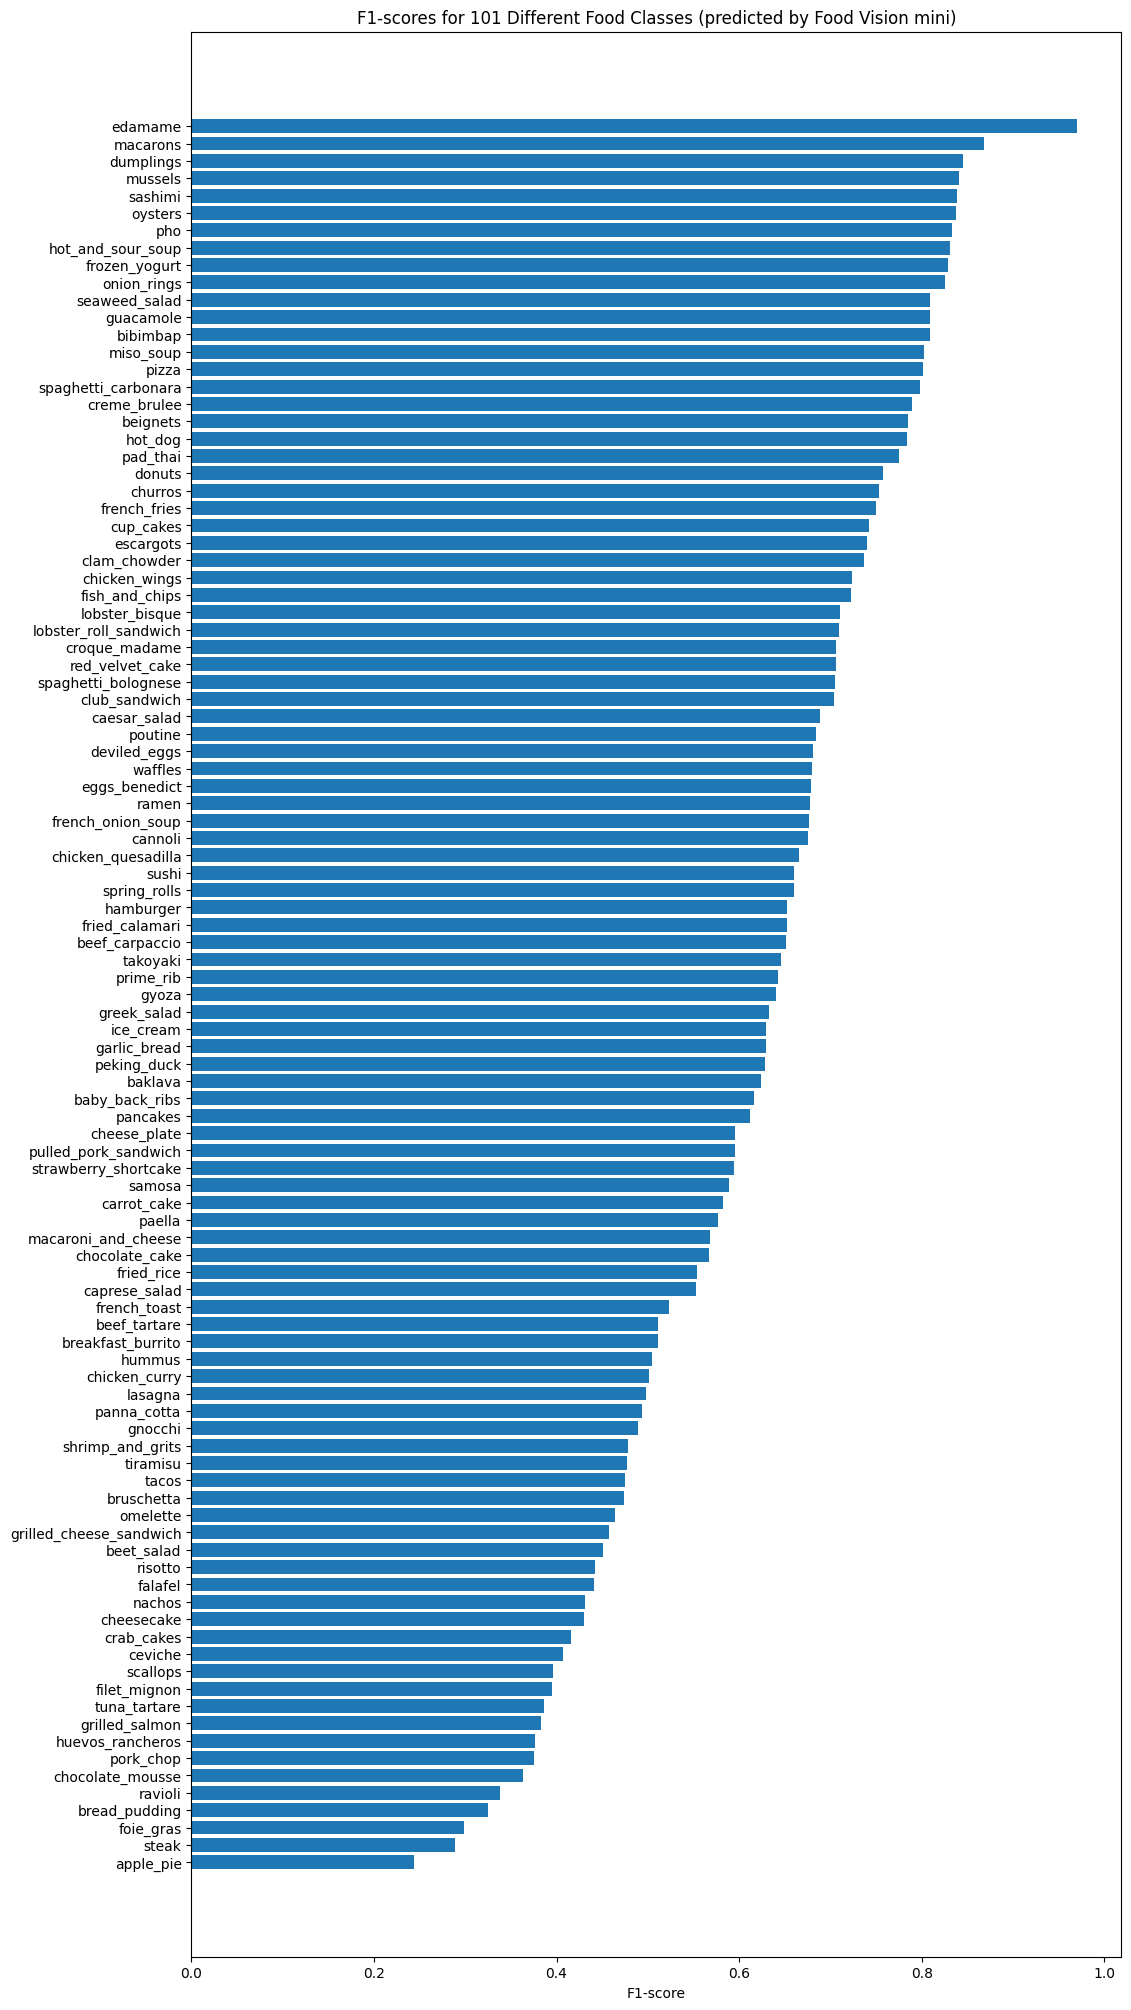

In [131]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

# Challenge: add values to the end of each bar of what the actual f1-score is
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)


# Visualizing predictions on test images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:

* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [132]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow


Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:

1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions,  prediction probability and truth label